# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
from torch import nn
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

c:\Users\milap\Anaconda\envs\llm_test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Check pytorch setup

In [3]:
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


# Data Prep
Define data path and load data in pandas dataframe.

In [39]:
data_filename = "AF50m_subset_REGEX_man_labels_5k.txt"
data_path = os.path.join("data", data_filename)
data = pd.read_csv(data_path, sep="\t")

Filter data so that we only keep annotations that have been manually labelled, and remove the note column.

In [40]:
lab_data = data[data["manual_label"].notna()].iloc[:, :-1]

Map string labels to integers and vice-versa:
- Uninformative <-> 0
- Low <-> 1
- Proper <-> 2

In [41]:
label_names = ["uninformative", "low", "proper"]
label2id = {label:id for id,label in enumerate(label_names)} # Label to id dict
id2label = {id:label for label,id in label2id.items()}       # Id to label dict

Ensure all labels in the data are correct (i.e. either "uninformative", "low", or "proper").

In [42]:
lab_data = lab_data.copy()
lab_data["manual_label"] = lab_data["manual_label"].str.strip().str.lower()
assert set(lab_data["manual_label"].unique()) <= set(label_names), "Unexpected label present."

Add column to lab_data containing the integer label ids.

In [43]:
lab_data["label_id"] = lab_data["manual_label"].map(label2id)

Training and validation sets accounting for class imbalance.


In [ ]:
train_df, val_test_df = train_test_split(
    lab_data,
    test_size=0.3,
    random_state=42,
    stratify=lab_data["label_id"]
)

val_df, test_df = train_test_split(
    val_test_df,
    test_size=1/3,
    random_state=42,
    stratify=val_test_df["label_id"]
)

# LLM

## Setting up the Tokenizer

Load PubMedBERT tokenizer from Hungging Face.  
A tokenizer converts raw text (strings) into numbers (token IDs).

In [45]:
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Helper function to tokenise batch of annotations

In [46]:
def tokenize_batch(texts):
    """
    Takes a list of protein annotations and applies the tokenizer to all of them.
    Arguments:
        texts: list of strings containing the protein annotations.
        max_len: integer indicating the max length of an annotation, needed for padding or truncating tokens.
    Returns:
        BatchEncoding object containing the encoded annotations
    """
    return tokenizer(
        texts,
        padding = True,
        truncation = True,
        max_length = 128
    )

Encoding of training and validation sets.

In [47]:
train_enc = tokenize_batch(texts = train_df["protein_annotation"].tolist())
val_enc = tokenize_batch(texts = val_df["protein_annotation"].tolist())
test_enc = tokenize_batch(texts = test_df["protein_annotation"].tolist())

train_enc and val_enc are BatchEncoding objects. We can access the data (dictionary object) within it as follows:

In [48]:
train_enc_dict = train_enc.data
train_enc_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [49]:
print(type(train_enc_dict["input_ids"]))
print(len(train_enc_dict["input_ids"]))
print(type(train_enc_dict["input_ids"][0]))
print(train_enc_dict["input_ids"][0])

<class 'list'>
3500
<class 'list'>
[2, 9518, 21, 3480, 6713, 16, 6770, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


The dictionary in the training and validation BatchEncoding objects contain 3 keys. They are lists containing more lists, one for each annotation.
- `input_ids`: each annotation has its own list within ´input_ids´, containing all the token ids for that annotation.
- `token_type_ids`: each annotation has its own list within `token_type_ids`, with a token type id for each token in that annotation. Token type ids indicate which sentence each token belongs to. In this case, it will always be 0 since each annotation consists of one sentence.
- `attention_mask`: each annotation has its own list within `attention_mask`, with a binary value for each token in that annotation. They indicate whether the token is a real token (1) or just padding (0).

Example of what the dictionary looks like:
```
{
    'input_ids': [[101, 11619, 3290, 7153, 2609, 102, 0, 0, ...], ...],
    'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, ...], ...],
    'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, ...], ...]
} 
```

Class that wraps tokenized annotations and labels into a PyTorch-friendly dataset.

In [50]:
class DS(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # The keys in the encoding object are input_ids, token_types_ids, and attention mask
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = DS(train_enc, train_df["label_id"].tolist())
val_ds = DS(val_enc, val_df["label_id"].tolist())
test_ds = DS(test_enc, test_df["label_id"].tolist())

In [51]:
train_ds.__getitem__(0)

{'input_ids': tensor([   2, 9518,   21, 3480, 6713,   16, 6770,    3,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(0)}

### Useful Information about Tokenisers

Accessing token ids

In [52]:
ids = train_enc["input_ids"][0]

Decoding token ids back to annotation

In [53]:
decoded_text = tokenizer.decode(ids)
decoded_text

'[CLS] activator 1 36 kda, putative [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Convert token to its corresponding id

In [54]:
tokenizer.convert_tokens_to_ids("[CLS]")


2

Convert id to its corresponding token

In [55]:
tokenizer.convert_ids_to_tokens(2)

'[CLS]'

Examples of token and corresponding ids
| Token          |  ID        |
| -------------- | ---------- |
| `[CLS]`        | 2          |
| `hypothetical` | 15148      |
| `protein`      | 2213       |
| `domain`       | 3418       |
| `phage`        | 10503      |
| `[SEP]`        | 3          |
| `[PAD]`        | 0          |

## Class Weights to Manage Imbalance

We use class weights to prevent the model to always predict the majority class (in this case the proper class).

In [56]:
classes = np.array(sorted(train_df["label_id"].unique()))
weights = compute_class_weight(
    class_weight = "balanced",
    classes = classes,
    y = train_df["label_id"].values
)
class_weights = torch.tensor(weights, dtype=torch.float)
class_weights

tensor([3.8126, 8.7065, 0.3813])

The rarer the class, the higher the weight.

## Weighted Model

Here, we define the weighted model. We are using a HuggingFace sequence classifier.

What is a Hugging Face sequence classifier?
A sequence classifier consists of a pretrained encoder (performs contextual/semantic embedding), on top of which HuggingFace automatically attaches a classification head (linear layer).

In our case, the pretrained encoder is PubMedBERT (trained on millions of PubMed abstracts and full-text biomedical papers), and then we train the classification head using our data. This final classification layer maps the final hidden representation to the three output classes.

In [58]:
### HuggingFace sequence classifier
# This automatically attaches a classification head on top of the pretrained encoder (PubMedBERT)
base_model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                num_labels=len(label_names),
                                                                id2label=id2label,
                                                                label2id=label2id)


# Custom subclass of the Hugging Face Trainer that overrides the compute_loss method.
# We override because we want to add class weights
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Performance Metrics

In [59]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "f1_uninformative": f1_score(labels, preds, average=None, labels=[0])[0],
        "f1_low": f1_score(labels, preds, average=None, labels=[1])[0],
        "f1_proper": f1_score(labels, preds, average=None, labels=[2])[0],
    }

## Function to Save Model and Tokenizer

In [60]:
def save(trainer, tokenizer, save_dir):
    trainer.save_model(save_dir)
    tokenizer.save_pretrained(save_dir)
    print(f"Model and Tokenizer saved to {save_dir}")

## Model Training

In [28]:
args = TrainingArguments(
    output_dir="bert_protein_ann_clf",
    eval_strategy="epoch",           
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_steps=50,
    seed=42,
    remove_unused_columns=True,   
)

trainer = WeightedTrainer(
    model=base_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

save(trainer, tokenizer, "model_test")

C:\Users\milap\AppData\Local\Temp\ipykernel_75396\2306115836.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Uninformative,F1 Low,F1 Proper
1,0.374300,0.365827,0.968000,0.900812,0.869565,0.850000,0.982870
2,0.302400,0.278102,0.974667,0.925849,0.892193,0.899083,0.986270
3,0.209200,0.278307,0.976667,0.935077,0.902985,0.915254,0.986993
4,0.041400,0.289731,0.975333,0.923828,0.898876,0.885246,0.987361


Model and Tokenizer saved to model_test


In [61]:
# Run model on validation set
predictions = trainer.predict(test_ds)

# Extract true and predicted labels
y_true = np.array(test_df["label_id"])
y_pred = np.argmax(predictions.predictions, axis=1)

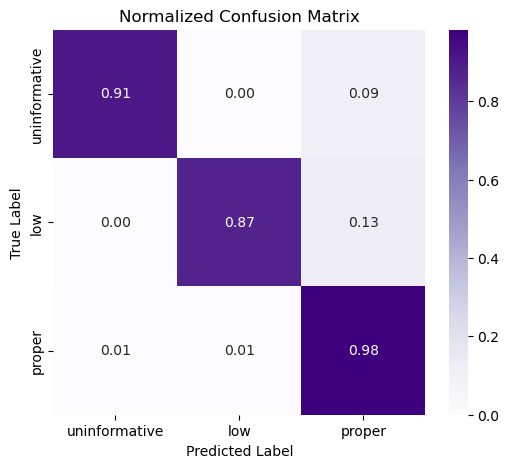

In [64]:
cm = confusion_matrix(y_true, y_pred, normalize="true")  # normalize by row (true label)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Purples", fmt=".2f",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()